# Dual Problem

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr) </div>

이전의 차원 변환 코드에서 2차원의 데이터를 3차원으로 확장하여 비선형 Decision Boundary를 그리는 법을 익혔습니다. 여기서 더 나아가, 3차원이 아닌 무한대 차까지 확장하여 데이터를 분류하는 방법이 Kernal Trick입니다.  
본 코드에서는 Kernal Trick을 배우기 전에 이해해야 할 2차계획법(Constrained quadratic programming)의 primal problem을 dual problem으로 변환하는 방법을 간단히 다루고 있습니다.  

### Lagrange Method를 통한 SVM의 Dual 변환
$$min_{w,b}||w||$$
$$s.t. (wx_j+b)y_j \leq 1, \forall j$$  
SVM에 쓰였던 위의 원 quadratic programming의 식을 Lagrange method를 활용하여 dual 함수로 나타내면 다음과 같습니다.
$$min_{w,b}max_{\alpha \leq 0, \beta}\frac{1}{2}w\cdot w \sum_{j}\alpha[(wx_j+b)y_j -1]$$
$$s.t. \alpha_j \leq 0, \forall j$$  

다음으로 Strong duality를 성립시키는 KKT(Karush-Kunh-Tucker) 조건은 다음과 같습니다.
$$\frac{\partial L(w,b,\alpha)}{\partial w}=0, \space \frac{\partial L(w,b,\alpha)}{\partial b}=0
$$
$$ \alpha_i \leq 0, \forall i $$
$$ \alpha_i((wx_j+b)y_j-1)=0, \forall i$$  

위의 편미분 방정식을 풀면 $w=\sum_{i=1}^{N}\alpha_i y_i x_i$, $\sum_{i=1}^{N}\alpha_i y_i = 0$의 결과를 얻을 수 있고, 이를 활용하여 $L(w,b,\alpha)$를 전개하면 다음과 같은 결과를 얻을 수 있습니다.
$$L(w,b,\alpha)=\sum_{j}\alpha_j - \frac{1}{2}\sum_{i}\sum_{j}\alpha_i\alpha_j y_i y_j x_i x_j$$  
기존 SVM이 $w$에 대한 최적화 문제였다면, dual problem은 $\alpha$에 대한 최적화 문제임을 위의 식을 통해 알 수 있습니다. 위의 식은 KKT 조건으로부터 유도된 식이므로, $\alpha$를 구할 수 있다면, 이를 통해 $w$ 역시 구할 수 있음을 알 수 있습니다.

In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Kim Hye-mi: khm0308@kaist.ac.kr
'''
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Positive / Negative 데이터 생성
pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5], [5, 5.2], [7, 5], [6, 3.75], [6, 4], [6, 5], [7, 5], [6, 4.5], [7, 4.5]])
neg = np.array([[4, 5], [5, 5], [6, 3], [7, 4], [9, 4], [5, 4], [5, 4.5], [5, 3.5], [7, 3.5]])

# 절충 매개변수
C = 0.1

# X: 전체 데이터를 저장
X = np.ones((pos.shape[0]+neg.shape[0], 2))
X[0:pos.shape[0], :] = pos # 앞부분은 positive 데이터를 저장
X[pos.shape[0]:pos.shape[0]+neg.shape[0], :] = neg # 뒷부분은 negative 데이터를 저장

# Y: 전체 데이터에 대한 label을 저장
Y = np.ones(pos.shape[0] + neg.shape[0])
Y[0:pos.shape[0]] = 1 # 앞부분은 positive 데이터에 대한 label로 +1을 저장
Y[pos.shape[0]:pos.shape[0]+neg.shape[0]] = -1 # 뒷부분은 negative 데이터에 대한 label로 -1을 저장

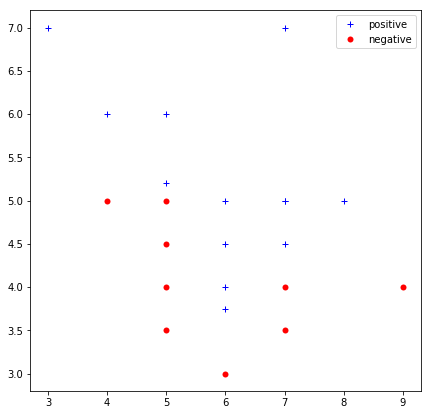

In [4]:
# 데이터셋 plotting
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'b+', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], 
         X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', markeredgecolor = 'None', label = 'negative')
plt.legend()
plt.show()

## Primal problem

In [46]:
A = np.zeros((X.shape[0] + X.shape[0], X.shape[1] + 1 + X.shape[0]))
    
for i in range(X.shape[0]): # for문 에서 제약식에서 (wx+b)y+e>=1 항의 좌측항을 업데이트함
    for j in range(X.shape[1]):
        #A[i, j] = X[i, j]*Y[i]
        A[i, j] = X[i, j]*Y[i]*(-1) # -xij＊yi
    #A[i, X.shape[1]] = Y[i]
    A[i, X.shape[1]] = Y[i]*(-1) # -bi
    A[i, X.shape[1] + i + 1] = -1 # -ei (error)
    
# 제약식에서 e>=0 항의 좌측항을 나타냄
for i in range(X.shape[0]):
    A[i + X.shape[0], X.shape[1] + i + 1] = -1
    
# b: optimization problem에서 제약식 우측항의 값
b = np.zeros((X.shape[0] + X.shape[0], 1))
# 제약식에서 (wx+b)y+e>=1 항의 우측항을 나타냄; e>=0 항의 우측항은 0으로 위에서 설정됨
b[0:X.shape[0]] = -1
    
# H: w의 quadratic term의 계수
H = np.zeros((X.shape[1] + 1 + X.shape[0], X.shape[1] + 1 + X.shape[0]))
for i in range(X.shape[1]):
    H[i, i] = 1

f = np.zeros(X.shape[1] + 1 + X.shape[0])
# w의 일차항의 계수로 에러항에 곱해줄 절충 매개변수 C (slack variable에 대한 계수)
for i in range(X.shape[1] + 1, X.shape[1] + 1 + X.shape[0]):
    f[i] = C

H = matrix(H)
f = matrix(f)
A = matrix(A)
b = matrix(b)
    
# optimization problem을 풀어줌: min 1/2xTHx+fTx s.t. Ax =< b
sol = solvers.qp(H, f, A, b)
w_prial = sol['x']

     pcost       dcost       gap    pres   dres
 0:  7.6558e-01  1.1329e+01  1e+02  2e+00  7e+01
 1:  4.3916e+00  1.0059e+00  3e+00  6e-03  2e-01
 2:  1.7279e+00  1.4104e+00  3e-01  5e-04  1e-02
 3:  1.6118e+00  1.5485e+00  6e-02  1e-04  3e-03
 4:  1.5942e+00  1.5823e+00  1e-02  1e-05  4e-04
 5:  1.5889e+00  1.5886e+00  3e-04  2e-07  7e-06
 6:  1.5888e+00  1.5888e+00  3e-06  3e-09  7e-08
 7:  1.5888e+00  1.5888e+00  3e-08  3e-11  7e-10
Optimal solution found.


## Dual Problem

In [47]:
# L(w, b, x)의 2차항의 계수 (ΣΣaiajxixjyiyj)
H = np.zeros((pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0]))

for i in range(pos.shape[0] + neg.shape[0]):
    for j in range(pos.shape[0] + neg.shape[0]):
        H[i,j] += np.dot(X[i,:], X[j, :]) * Y[i] * Y[j] * -1

# L(w, b, x)의 1차수의 계수 (0)
f = np.ones(pos.shape[0] + neg.shape[0])

H = -1*H
f = -1*f

# ai > C
A = np.zeros((pos.shape[0] + neg.shape[0] + pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0]))
b = np.zeros(pos.shape[0] + neg.shape[0] + pos.shape[0] + neg.shape[0])

for i in range(pos.shape[0] + neg.shape[0]):
    A[i, i] = -1
    A[i + pos.shape[0] + neg.shape[0], i] = 1
    b[i + pos.shape[0] + neg.shape[0]] = C

# KKT 조건 중 Σaiyi = 0 의 계수
Aeq = np.zeros((1, pos.shape[0] + neg.shape[0]))
Beq = np.zeros((1, 1))

for i in range(pos.shape[0] + neg.shape[0]):
    Aeq[0, i] = Y[i]

f = matrix(f)
H = matrix(H)
A = matrix(A)
b = matrix(b)
Aeq = matrix(Aeq)
Beq = matrix(Beq)

# optimization problem을 풀어줌: min 1/2xTHx+fTx s.t. Ax =< b, A_eq x = Beq
sol = solvers.qp(H, f, A, b, Aeq, Beq)
alpha = sol['x']

     pcost       dcost       gap    pres   dres
 0: -7.7115e+00 -4.6032e+00  1e+02  1e+01  2e-14
 1: -1.2660e+00 -4.4002e+00  3e+00  2e-02  2e-14
 2: -1.4166e+00 -1.7287e+00  3e-01  2e-03  4e-15
 3: -1.5495e+00 -1.6119e+00  6e-02  4e-04  6e-15
 4: -1.5825e+00 -1.5942e+00  1e-02  6e-05  6e-15
 5: -1.5886e+00 -1.5889e+00  3e-04  1e-06  7e-15
 6: -1.5888e+00 -1.5888e+00  3e-06  1e-08  4e-15
 7: -1.5888e+00 -1.5888e+00  3e-08  1e-10  4e-15
Optimal solution found.


In [48]:
# w = Σ aiyixi
w = np.zeros(pos.shape[1] + 1)
for j in range(pos.shape[1]):
    for i in range(pos.shape[0] + neg.shape[0]):
        w[j] += alpha[i]*Y[i]*X[i,j]

# b = yi - w(=Σ aiyixi)
wx = np.asarray(np.dot(w[0:pos.shape[1]], X.T))
bs = Y - wx
w[2] = bs[1]

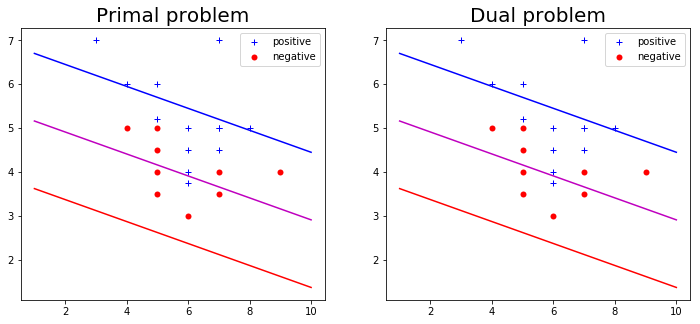

In [59]:
# Positive / Negative 데이터 plotting
#plt.figure(1, figsize = (7, 7))
plt.figure(1, figsize = (12, 5))
plt.subplot(121)
plt.title('Primal problem', fontsize = 20)
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'b+', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], 
         X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', markeredgecolor = 'None', label = 'negative')
plt.legend()

lineX = [1, 10]
    
# plotting decision-boundary
lineY0 = [(w_prial[2] + w_prial[0]*lineX[0])/-w_prial[1], (w_prial[2] + w_prial[0]*lineX[1])/-w_prial[1]]
plt.plot(lineX, lineY0, 'm-')

# margin distance 계산
margin = 1 / np.linalg.norm(w_prial[0:2])

# Positive data 가운데 Negative data들과 가장 가까운 두개의 점을 지나는 직선
lineY1 = [(w_prial[2] + w_prial[0]*lineX[0])/-w_prial[1] + margin, (w_prial[2] + w_prial[0]*lineX[1])/-w_prial[1] + margin]
plt.plot(lineX, lineY1, 'b-')

# Negative data 가운데 Negative data들과 가장 가까운 점을 지나는 직선
lineY2 = [(w_prial[2] + w_prial[0]*lineX[0])/-w_prial[1] - margin, (w_prial[2] + w_prial[0]*lineX[1])/-w_prial[1] - margin]
plt.plot(lineX, lineY2, 'r-')
    
print('')

# Positive / Negative 데이터 plotting
plt.subplot(122)
#plt.figure(2, figsize = (7, 7))
plt.title('Dual problem', fontsize = 20)
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'b+', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], 
         X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', markeredgecolor = 'None', label = 'negative')
plt.legend()

lineX = [1, 10]

# plotting decision-boundary
lineY0 = [(w[2] + w[0]*lineX[0])/-w[1], (w[2] + w[0]*lineX[1])/-w[1]]
plt.plot(lineX, lineY0, 'm-')

# margin distance 계산
margin = 1 / np.linalg.norm(w[0:2])

# decision-boundary에서 margin distance만큼 떨어진 직선
lineY1 = [(w[2] + w[0]*lineX[0])/-w[1] + margin, (w[2] + w[0]*lineX[1])/-w[1] + margin]
plt.plot(lineX, lineY1, 'b-')

# decision-boundary에서 margin distance만큼 떨어진 직선
lineY2 = [(w[2] + w[0]*lineX[0])/-w[1] - margin, (w[2] + w[0]*lineX[1])/-w[1] - margin]
plt.plot(lineX, lineY2, 'r-')

plt.show()

## 결과해석부
왼쪽 그래프는 Primal 문제의 최적화 식을 푼 결과입니다. 오른쪽 그래프는 (Primal 문제에 대한) Dual 문제의 최적화 식을 푼 결과입니다. 이 그래프를 통해 Primal Problem과 KKT 조건을 만족하는 Dual Problem의 결과는 동일함을 알 수 있습니다.